# SisFall Dataset Preparation for ESP32 Fall Detection

This notebook prepares the SisFall dataset for machine learning model training on an ESP32-based wearable. It reads raw accelerometer files, processes each recording file by file, and ultimately produces clean numpy arrays for efficient training and inference.

---

## 1. File Structure and Setup

The SisFall dataset is structured in subject folders (`SA01`–`SA23` for adults, `SE01`–`SE15` for elderly). Each folder contains multiple `.txt` files, with each file representing one activity or trial (fall or non-fall).

Our processing will:
- Traverse all subject folders,
- Collect paths to every activity file,
- Retain subject/activity information for downstream splits and labeling.

---

In [38]:
#install necessary packages
%pip install numpy scipy matplotlib pandas scikit-learn tqdm

Note: you may need to restart the kernel to use updated packages.


In [25]:
# 1.1 Imports

import os
import glob
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# For progress bars during bulk file processing
from tqdm import tqdm

## 2. Define Base Paths and Key Parameters

Specify the path to your `SisFall_dataset` folder, the key processing parameters (input/output rates, window sizes, ADXL345 accelerometer scaling, etc.), and the Butterworth filter configuration for downsampling.

---

In [26]:
# 2.1 Paths and Parameters

# Update this path to match your folder structure
BASE_DATA_DIR = "./SisFall_dataset"

# Output directory for processed data
OUTPUT_DIR = "./prepared_dataset_50hz"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# SisFall sampling and feature extraction configs
FS_IN = 200
FS_OUT = 50
DECIM = FS_IN // FS_OUT

WIN_SECONDS = 1.0
WINDOW_SIZE = int(FS_OUT * WIN_SECONDS)
OVERLAP = 0.5
STEP = int(WINDOW_SIZE * (1 - OVERLAP))

# ADXL345 scaling for ±16g, 13-bit data
ADXL345_SCALE_G_PER_LSB = (2 * 16) / (2**13)  # = 0.00390625 g/LSB

# Butterworth low-pass filter config
LP_CUTOFF_HZ = 20.0
BUTTER_ORDER = 4


## 3. Collect All Text File Paths

Locate all activity `.txt` files for all subjects, keeping full relative paths. This enables subsequent mapping from file names to subject and activity type.

---

In [27]:
# 3.1 Find all .txt data files in the dataset directory
all_txt_files = sorted(glob.glob(os.path.join(BASE_DATA_DIR, "SA??", "*.txt")) +
                    glob.glob(os.path.join(BASE_DATA_DIR, "SE??", "*.txt")))
print(f"Found {len(all_txt_files)} .txt files.")


Found 4505 .txt files.


## Step 4 — Define subject-wise splits and label mapping

To prevent data leakage and assess generalization to unseen people, split by subject IDs, not by random windows. Adults (SA) provide both ADLs and falls; elderly (SE) mostly provide ADLs, with SE06 also simulating falls. Labels come from filename codes: Fxx = Fall (1), Dxx = Non‑Fall (0).  


In [28]:
# 4.1 Subject splits
TRAIN_SUBJECTS = [f"SA{str(i).zfill(2)}" for i in range(1, 19)]   # SA01–SA18
VAL_SUBJECTS   = [f"SA{str(i).zfill(2)}" for i in range(19, 22)]  # SA19–SA21
TEST_SUBJECTS_A = [f"SA{str(i).zfill(2)}" for i in range(22, 24)] # SA22–SA23 (adult generalization test)
TEST_SUBJECTS_B = [f"SE{str(i).zfill(2)}" for i in range(1, 16)]  # SE01–SE15 (elderly robustness test)

def file_to_subject_and_label(path):
    base = os.path.basename(path)
    stem = os.path.splitext(base)[0]
    activity_code, subject_id, _ = stem.split('_')
    label = 1 if activity_code.startswith('F') else 0
    return subject_id, label


## Step 5 — Read ADXL345 axes and convert to g

Each SisFall file has nine columns; only columns 1–3 are ADXL345 accelerometer axes X, Y, Z. Convert raw counts to physical units using the ADXL345 full‑resolution factor (~0.00390625 g/LSB) for consistent scaling across files.  


In [29]:
# 5.1 Load ADXL345 XYZ counts (columns 0,1,2) and convert to g
ADXL345_SCALE_G_PER_LSB = (2 * 16) / (2**13)  # 0.00390625

def load_adxl345_xyz_counts(path):
    df = pd.read_csv(
        path,
        header=None,
        usecols=[0, 1, 2],
        engine='python',
        on_bad_lines='skip'
    )
    return df.astype(np.float32).to_numpy()

def counts_to_g(ad_counts):
    return ad_counts * ADXL345_SCALE_G_PER_LSB


## Step 6 — Anti‑alias filtering and decimation to 50 Hz

Downsample 200 Hz → 50 Hz by first low‑pass filtering around 20 Hz to avoid aliasing, then taking every 4th sample. Zero‑phase filtering preserves impact timing.  


In [30]:
# 6.1 Filter design and decimation helper
from scipy.signal import butter, filtfilt

FS_IN = 200
FS_OUT = 50
DECIM = FS_IN // FS_OUT  # 4

LP_CUTOFF_HZ = 20.0
BUTTER_ORDER = 4

def design_lowpass(fs, cutoff_hz, order=4):
    b, a = butter(order, cutoff_hz, btype='low', fs=fs)
    return b, a

B_LP, A_LP = design_lowpass(FS_IN, LP_CUTOFF_HZ, BUTTER_ORDER)

def lowpass_then_decimate(x_xyz_g, b, a, decim):
    xf = filtfilt(b, a, x_xyz_g, axis=0)
    return xf[::decim, :]


## Step 7 — Windowing (1 s, 50% overlap) and magnitude channel

Split each processed sequence into fixed windows of 1.0 s at 50 Hz (50 samples) with 50% overlap to capture transitions. Add an acceleration magnitude channel |A| to emphasize impacts.  


In [31]:
# 7.1 Window and feature helpers
FS_OUT = 50
WIN_SECONDS = 1.0
WINDOW_SIZE = int(FS_OUT * WIN_SECONDS)  # 50
OVERLAP = 0.5
STEP = int(WINDOW_SIZE * (1 - OVERLAP)) # 25

def sliding_windows(arr, window, step):
    N, C = arr.shape
    if N < window:
        return np.empty((0, window, C))
    starts = np.arange(0, N - window + 1, step, dtype=int)
    return np.stack([arr[s:s+window] for s in starts], axis=0)

def add_magnitude_channel(xyz_g):
    mag = np.linalg.norm(xyz_g, axis=1, keepdims=True)
    return np.concatenate([xyz_g, mag], axis=1)  # (N, 4)


## Step 8 — Process each file and assemble datasets

Now iterate over every SisFall file, route it to Train/Val/TestA/TestB based on the subject ID, then apply the full preprocessing chain:
1) read ADXL345 counts (cols 1–3)  
2) convert to g  
3) low‑pass filter and decimate to 50 Hz  
4) add magnitude channel  
5) window into 1 s segments with 50% overlap  
Finally, append windows and labels to their respective split lists.


In [32]:
# Step 8 — Build datasets per split

X_train, y_train = [], []
X_val,   y_val   = [], []
X_testA, y_testA = [], []  # Adult generalization test (e.g., SA22–SA23)
X_testB, y_testB = [], []  # Elderly robustness test (SE01–SE15)

for fpath in tqdm(all_txt_files, desc="Processing files"):
    subject_id, label = file_to_subject_and_label(fpath)

    # Route to the correct split
    if subject_id in TRAIN_SUBJECTS:
        dest_X, dest_y = X_train, y_train
    elif subject_id in VAL_SUBJECTS:
        dest_X, dest_y = X_val, y_val
    elif subject_id in TEST_SUBJECTS_A:
        dest_X, dest_y = X_testA, y_testA
    elif subject_id in TEST_SUBJECTS_B:
        dest_X, dest_y = X_testB, y_testB
    else:
        continue  # skip any unexpected subject folders

    # 1) Read ADXL345 counts, 2) convert to g
    counts_xyz = load_adxl345_xyz_counts(fpath)     # (N, 3)
    accel_g    = counts_to_g(counts_xyz)            # (N, 3)

    # 3) Low-pass filter + decimate to 50 Hz
    accel_50   = lowpass_then_decimate(accel_g, B_LP, A_LP, DECIM)  # (N', 3)

    # 4) Add magnitude channel
    seq4 = add_magnitude_channel(accel_50)          # (N', 4)

    # 5) Window into 1 s segments
    wins = sliding_windows(seq4, WINDOW_SIZE, STEP)  # (W, 50, 4)

    if wins.shape[0] > 0:
        dest_X.append(wins)
        dest_y.append(np.full((wins.shape[0],), label, dtype=np.int64))

# Concatenate lists into arrays
def cat_or_empty(X_list, y_list, T=WINDOW_SIZE, C=4):
    X = np.concatenate(X_list, axis=0) if len(X_list) else np.empty((0, T, C), dtype=np.float32)
    y = np.concatenate(y_list, axis=0) if len(y_list) else np.empty((0,), dtype=np.int64)
    return X, y

X_train, y_train = cat_or_empty(X_train, y_train)
X_val,   y_val   = cat_or_empty(X_val,   y_val)
X_testA, y_testA = cat_or_empty(X_testA, y_testA)
X_testB, y_testB = cat_or_empty(X_testB, y_testB)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape,   y_val.shape)
print("TestA:", X_testA.shape, y_testA.shape)
print("TestB:", X_testB.shape, y_testB.shape)


Processing files: 100%|██████████| 4505/4505 [00:26<00:00, 170.78it/s]

Train: (91249, 50, 4) (91249,)
Val  : (15099, 50, 4) (15099,)
TestA: (10169, 50, 4) (10169,)
TestB: (37554, 50, 4) (37554,)


## Step 9 — Standardize features using training statistics

To stabilize training and keep distributions consistent across splits, compute per‑channel mean and std from X_train only, then apply z‑score standardization to train/val/test sets. Save these stats for use during on‑device preprocessing so live data is scaled the same way.


In [33]:
# Step 9 — Compute and apply standardization
def compute_channel_stats(X):
    # X: (N, T, C) -> collapse N and T to compute per-channel stats
    flat = X.reshape(-1, X.shape[-1])
    mean = flat.mean(axis=0).astype(np.float32)
    std  = flat.std(axis=0).astype(np.float32)
    std[std == 0] = 1.0
    return mean, std

def apply_standardization(X, mean, std):
    return (X - mean.reshape(1,1,-1)) / std.reshape(1,1,-1)

ch_mean, ch_std = compute_channel_stats(X_train)
X_train = apply_standardization(X_train, ch_mean, ch_std)
X_val   = apply_standardization(X_val,   ch_mean, ch_std)
X_testA = apply_standardization(X_testA, ch_mean, ch_std)
X_testB = apply_standardization(X_testB, ch_mean, ch_std)

print("Channel mean:", ch_mean)
print("Channel std :", ch_std)


Channel mean: [-0.01102858 -0.65751654 -0.0801122   1.044303  ]
Channel std : [0.4364462  0.6011266  0.48854646 0.37257862]


## Step 10 — Save arrays and a preprocessing manifest

Persist the processed arrays and a manifest JSON that records every preprocessing choice (filter, downsampling, window size, channel names, subject splits, and scaling stats). This guarantees exact reproducibility and makes it easy to load data for training and to mirror preprocessing on ESP32.


In [34]:
# Step 10 — Save to disk
import json, os

os.makedirs(OUTPUT_DIR, exist_ok=True)

np.save(os.path.join(OUTPUT_DIR, "X_train.npy"), X_train)
np.save(os.path.join(OUTPUT_DIR, "y_train.npy"), y_train)
np.save(os.path.join(OUTPUT_DIR, "X_val.npy"),   X_val)
np.save(os.path.join(OUTPUT_DIR, "y_val.npy"),   y_val)
np.save(os.path.join(OUTPUT_DIR, "X_testA.npy"), X_testA)
np.save(os.path.join(OUTPUT_DIR, "y_testA.npy"), y_testA)
np.save(os.path.join(OUTPUT_DIR, "X_testB.npy"), X_testB)
np.save(os.path.join(OUTPUT_DIR, "y_testB.npy"), y_testB)

manifest = {
    "fs_in": 200,
    "fs_out": 50,
    "decimation": 4,
    "lp_cutoff_hz": 20.0,
    "butter_order": 4,
    "window_size": 50,
    "overlap": 0.5,
    "step": 25,
    "channels": ["Ax_g", "Ay_g", "Az_g", "A_mag_g"],
    "adxl345_scale_g_per_lsb": float((2*16)/(2**13)),
    "train_subjects": TRAIN_SUBJECTS,
    "val_subjects": VAL_SUBJECTS,
    "test_subjects_A": TEST_SUBJECTS_A,
    "test_subjects_B": TEST_SUBJECTS_B,
    "channel_mean": [float(x) for x in ch_mean],
    "channel_std":  [float(x) for x in ch_std],
    "counts": {
        "train": int(X_train.shape[0]),
        "val":   int(X_val.shape[0]),
        "testA": int(X_testA.shape[0]),
        "testB": int(X_testB.shape[0])
    }
}

with open(os.path.join(OUTPUT_DIR, "preprocessing_manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2)

print("Saved arrays and manifest to:", OUTPUT_DIR)


Saved arrays and manifest to: ./prepared_dataset_50hz


## Optional — Quick sanity plots

Visualize a few random windows from each split to confirm scaling, filtering, and magnitude behavior. This helps catch anomalies before training.


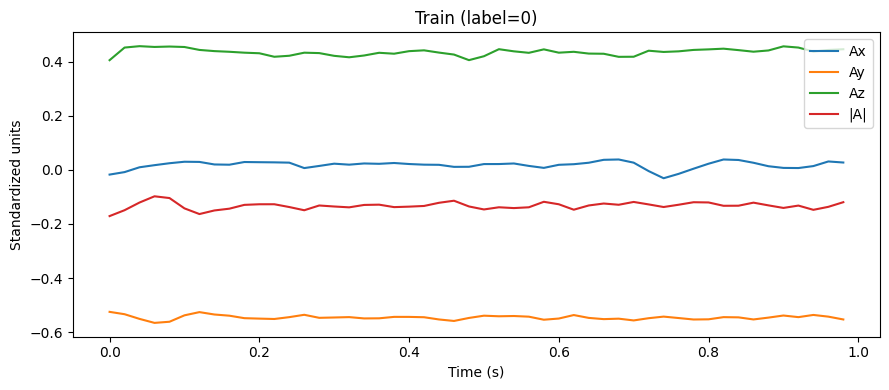

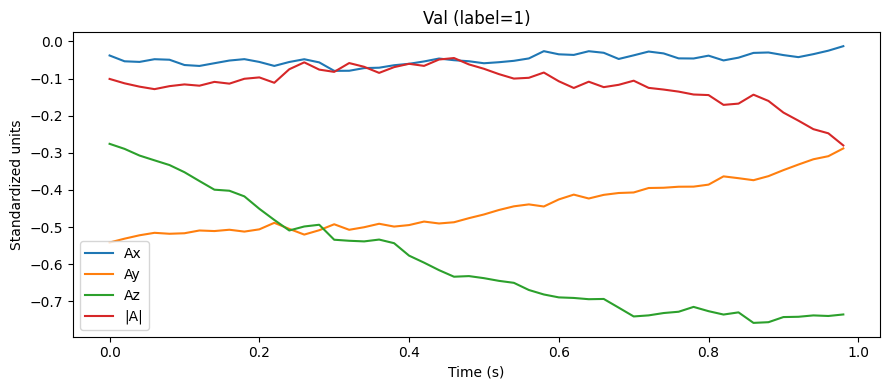

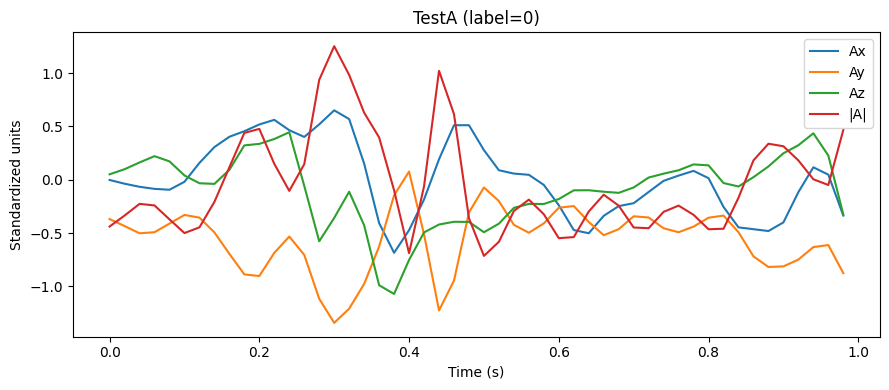

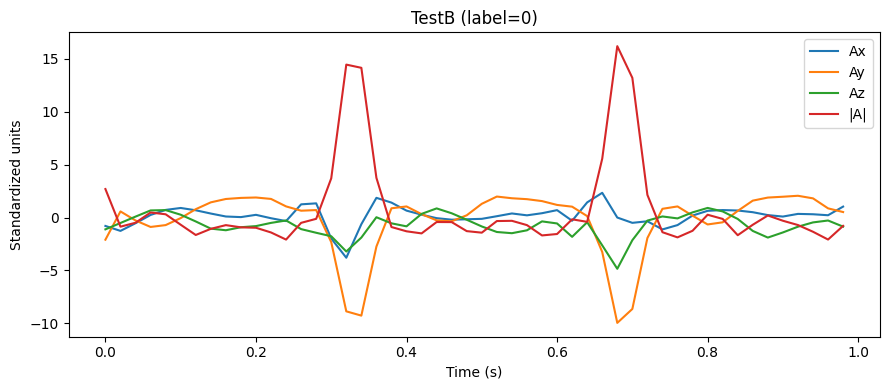

In [36]:
# Optional: Plot a random window from each split
import matplotlib.pyplot as plt
rng = np.random.default_rng(0)

def plot_random(X, y, title):
    if X.shape[0] == 0:
        print(f"No samples in {title}")
        return
    idx = rng.integers(0, X.shape[0])
    t = np.arange(X.shape[1]) / 50.0  # 50 Hz
    plt.figure(figsize=(9,4))
    plt.plot(t, X[idx,:,0], label="Ax")
    plt.plot(t, X[idx,:,1], label="Ay")
    plt.plot(t, X[idx,:,2], label="Az")
    plt.plot(t, X[idx,:,3], label="|A|")
    plt.title(f"{title} (label={y[idx]})")
    plt.xlabel("Time (s)")
    plt.ylabel("Standardized units")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_random(X_train, y_train, "Train")
plot_random(X_val,   y_val,   "Val")
plot_random(X_testA, y_testA, "TestA")
plot_random(X_testB, y_testB, "TestB")


## Step 11 — Check class balance per split

Verify how many Fall vs Non‑Fall windows exist in Train, Val, TestA, and TestB to ensure labels are correct and that splits match expectations (TestB should be overwhelmingly Non‑Fall because elderly subjects rarely have falls) [web:79].  
This also helps decide whether to use class weights during model training to compensate for imbalance and protect fall recall [web:42].  


In [37]:
# Step 11 — Class balance summary

def summarize_split(name, y):
    total = int(y.shape[0])
    falls = int((y == 1).sum())
    adl = total - falls
    pct_fall = 100.0 * falls / total if total > 0 else 0.0
    pct_adl  = 100.0 * adl  / total if total > 0 else 0.0
    print(f"{name}: total={total}, falls={falls} ({pct_fall:.2f}%), non-fall={adl} ({pct_adl:.2f}%)")

summarize_split("Train", y_train)
summarize_split("Val",   y_val)
summarize_split("TestA", y_testA)  # adult holdout
summarize_split("TestB", y_testB)  # elderly robustness


Train: total=91249, falls=39146 (42.90%), non-fall=52103 (57.10%)
Val: total=15099, falls=6467 (42.83%), non-fall=8632 (57.17%)
TestA: total=10169, falls=4348 (42.76%), non-fall=5821 (57.24%)
TestB: total=37554, falls=2175 (5.79%), non-fall=35379 (94.21%)
